# Sample run for Fisher Market

In [1]:
using Pkg
Pkg.activate("../")

  Activating project at `c:\Users\gggzy\Desktop\Z\mkt\ExchangeMarket.jl\scripts`


In [1]:
using Revise
using Random, SparseArrays, LinearAlgebra
using JuMP, MosekTools
using Plots, LaTeXStrings, Printf
import MathOptInterface as MOI

using ExchangeMarket

include("../tools.jl")
include("../plots.jl")
include("./setup.jl")
switch_to_pdf(; bool_use_html=false)

:pdf

## Test different $\rho$ in a CES Economy

Run CES economy by different methods

In [2]:
Random.seed!(1)
rrange = [-0.9, 0.9]
n = 500
m = 1000

method_filter(name) = name ∈ [:LogBar, :PathFol, :Tât, :PropRes]

method_filter (generic function with 1 method)

In [3]:
table_time = []
results = []
results_phi = Dict()
results_ground = Dict()
for ρ in rrange
    f0 = FisherMarket(m, n; ρ=ρ, bool_unit=true, scale=30.0, sparsity=0.2)
    linconstr = LinearConstr(1, n, ones(1, n), [sum(f0.w)])
    ρfmt = @sprintf("%+.2f", ρ)
    σfmt = @sprintf("%+.2f", f0.σ[1])
    # -----------------------------------------------------------------------
    # compute ground truth
    # -----------------------------------------------------------------------
    f1 = copy(f0)
    p₀ = ones(n) * sum(f1.w) ./ (n)
    x₀ = ones(n, m) ./ m
    f1.x .= x₀
    f1.p .= p₀
    # use log-barrier method to compute ground truth
    (name, method, kwargs) = method_kwargs[1]
    alg = method(
        n, m, p₀;
        linconstr=linconstr,
        kwargs...
    )
    traj = opt!(
        alg, f1;
        # loginterval=1,
        keep_traj=true
    )
    pₛ = copy(alg.p)
    results_phi[ρ] = pₛ
    results_ground[ρ] = (alg, traj, f1)
    for (name, method, kwargs) in method_kwargs
        !method_filter(name) && continue

        f1 = copy(f0)
        p₀ = ones(n) * sum(f1.w) ./ (n)
        x₀ = ones(n, m) ./ m
        f1.x .= x₀
        f1.p .= p₀
        alg = method(
            n, m, p₀;
            linconstr=linconstr,
            kwargs...
        )
        traj = opt!(
            alg, f1;
            keep_traj=true,
            pₛ=pₛ,
            maxiter=500
        )
        push!(results, ((name, ρ), (alg, traj, f1)))
        push!(table_time, (n, m, name, ρ, traj[end].t))
    end
end


FisherMarket initialization started...
FisherMarket cost matrix initialized in 0.1510 seconds
FisherMarket initialized in 0.2250 seconds
FisherMarket initialization started...
FisherMarket cost matrix initialized in 0.0120 seconds
FisherMarket initialized in 0.0120 seconds
----------------------------------------------------------------------------------
              ExchangeMarket.jl: A Julia Package for Exchange Market              
                              © Chuwen Zhang (2024)                              
----------------------------------------------------------------------------------
 subproblem solver alias       := CESAnalytic
 subproblem solver style       := analytic
 option for gradient           := dual
 option for step               := logbar
 option for μ                  := pred_corr
----------------------------------------------------------------------------------
running Phase I...
      k |  lg(μ) |             φ |    |∇φ| |    |Δp| |       t |      tₗ |      

## Validate the ground truth

In [4]:
for (ρ, (alg, traj, f1)) in results_ground
    validate(f1, alg)
end

------------------------------------------------------------
 :problem size
 :    number of agents: 1000
 :    number of goods: 500
 :    avg number of nonzero entries in c: 0.1997
 :equilibrium information
 :method: HessianBar
------------------------------------------------------------
10×2 DataFrame
 Row │ utility     left_budget  
     │ Float64     Float64      
─────┼──────────────────────────
   1 │ 1.24158e-7  -1.35525e-20
   2 │ 3.80644e-6  -2.1684e-19
   3 │ 1.89542e-6   0.0
   4 │ 2.95614e-8   0.0
   5 │ 1.29002e-6   1.0842e-19
   6 │ 4.36207e-7   5.42101e-20
   7 │ 1.79382e-6  -2.1684e-19
   8 │ 1.21595e-6  -2.1684e-19
   9 │ 1.31283e-7  -6.77626e-21
  10 │ 2.68664e-6   0.0
------------------------------------------------------------
 :(normalized) market excess: [-5.6658e-10, 5.1748e-10]
 :            social welfare:  -1.30839518e+01
------------------------------------------------------------
------------------------------------------------------------
 :problem size
 :  

In [5]:
using JuMP, MosekTools
import MathOptInterface as MOI
using ExchangeMarket

function eg_conic_ces!(f; ρ=-0.9, tol=1e-10, verbose=false)
    n, m = f.n, f.m
    model = ExchangeMarket.__generate_empty_jump_model(; verbose=verbose, tol=tol)

    @variable(model, x[1:n, 1:m] >= 0)     # n(goods) × m(agents)
    @variable(model, xp[1:n, 1:m] >= 0)    # xp ≈ x^ρ
    ExchangeMarket.powerp_to_cone.(xp, x, model, ρ)

    @constraint(model, limit, x * ones(m) .<= f.q)

    @variable(model, u[1:m] >= 0)
    @variable(model, logu[1:m])
    for i in 1:m
        @constraint(model, u[i] == sum(f.c[:, i] .* xp[:, i]))
        ExchangeMarket.log_to_expcone!(u[i], logu[i], model)
    end

    @objective(model, Max, sum(f.w[i] * logu[i] for i in 1:m) / ρ)
    optimize!(model)

    f.x .= value.(x)
    p = -dual.(limit)
    f.p .= p
    return p
end
f0 = FisherMarket(m, n; ρ=0.9, bool_unit=true, scale=30.0, sparsity=0.2)
linconstr = LinearConstr(1, n, ones(1, n), [sum(f0.w)])
f1 = copy(f0)
p_eq = eg_conic_ces!(f1; ρ=0.9, tol=1e-10)
alg = Conic(f1.n, f1.m; tol=1e-10); alg.p .= p_eq
validate(f1, alg)


FisherMarket initialization started...
FisherMarket cost matrix initialized in 0.0040 seconds
FisherMarket initialized in 0.0200 seconds
FisherMarket initialization started...
FisherMarket cost matrix initialized in 0.0160 seconds
FisherMarket initialized in 0.0160 seconds
------------------------------------------------------------
 :problem size
 :    number of agents: 1000
 :    number of goods: 500
 :    avg number of nonzero entries in c: 0.1997
 :equilibrium information
 :method: Conic
------------------------------------------------------------
10×2 DataFrame
 Row │ utility  left_budget  
     │ Float64  Float64      
─────┼───────────────────────
   1 │     0.0   8.50396e-10
   2 │     0.0  -7.70858e-9
   3 │     0.0  -3.01014e-9
   4 │     0.0   1.16792e-9
   5 │     0.0  -1.19279e-9
   6 │     0.0  -4.96925e-10
   7 │     0.0  -3.66905e-9
   8 │     0.0  -1.16617e-9
   9 │     0.0   1.17727e-9
  10 │     0.0  -4.20603e-9
-------------------------------------------------------

In [6]:
p_eq

500-element Vector{Float64}:
 0.001957892676443175
 0.0020000975405022594
 0.0020302975732711093
 0.001997257008775726
 0.0020520271941998312
 0.002012888567670968
 0.0019181439896892682
 0.001961950797615461
 0.0020486801163104988
 0.002032567021439491
 ⋮
 0.001992676708539295
 0.002050601411043221
 0.001972693760742559
 0.0020526455821076664
 0.0020190630821966715
 0.001977758512200733
 0.002044071246857587
 0.001989059083793434
 0.0019854180554771837

## Plot trajectory 

for each $\rho$, we plot the distance to ground truth $\|p - p^*\|$ of the trajectory.

In [ ]:
ffs = []
for ρ in rrange
    for attr in [:k]
        ρfmt = @sprintf("%+.2f", ρ)
        σfmt = @sprintf("%+.2f", ρ / (1 - ρ))
        fig = generate_empty(; shape=:wide)
        plot!(
            fig,
            ylabel=L"$\|\mathbf{p} - \mathbf{p}^*\|$",
            title=L"$\rho := %$ρfmt~(\sigma := %$σfmt)$",
            legendbackgroundcolor=RGBA(1.0, 1.0, 1.0, 0.8),
            yticks=10.0 .^ (-16:4:3),
            xtickfont=font(18),
            ytickfont=font(18),
            xscale=:identity,
            size=(1200, 600)
        )
        if attr == :k
            plot!(
                fig,
                xticks=[10, 20, 50, 100, 200, 500]
            )
        end
        for ((mm, _ρ), (alg, traj, f1)) in results
            if _ρ != ρ
                continue
            end
            traj_pp₊ = map(pp -> pp.D, traj)
            traj_tt₊ = map(pp -> getfield(pp, attr), traj)
            plot!(fig, traj_tt₊, traj_pp₊, label=L"\texttt{%$mm}", linewidth=2, linestyle=:dash, markershape=:circle)
        end
        push!(ffs, fig)
    end
end

------------------------------------------------------------
 :problem size
 :    number of agents: 1000
 :    number of goods: 500
 :    avg number of nonzero entries in c: 0.1997
 :equilibrium information
 :method: Conic
------------------------------------------------------------
10×2 DataFrame
 Row │ utility  left_budget  
     │ Float64  Float64      
─────┼───────────────────────
   1 │     0.0   8.50396e-10
   2 │     0.0  -7.70858e-9
   3 │     0.0  -3.01014e-9
   4 │     0.0   1.16792e-9
   5 │     0.0  -1.19279e-9
   6 │     0.0  -4.96925e-10
   7 │     0.0  -3.66905e-9
   8 │     0.0  -1.16617e-9
   9 │     0.0   1.17727e-9
  10 │     0.0  -4.20603e-9
------------------------------------------------------------
 :(normalized) market excess: [-3.3494e-09, 5.6992e-09]
 :            social welfare:  -Inf
------------------------------------------------------------


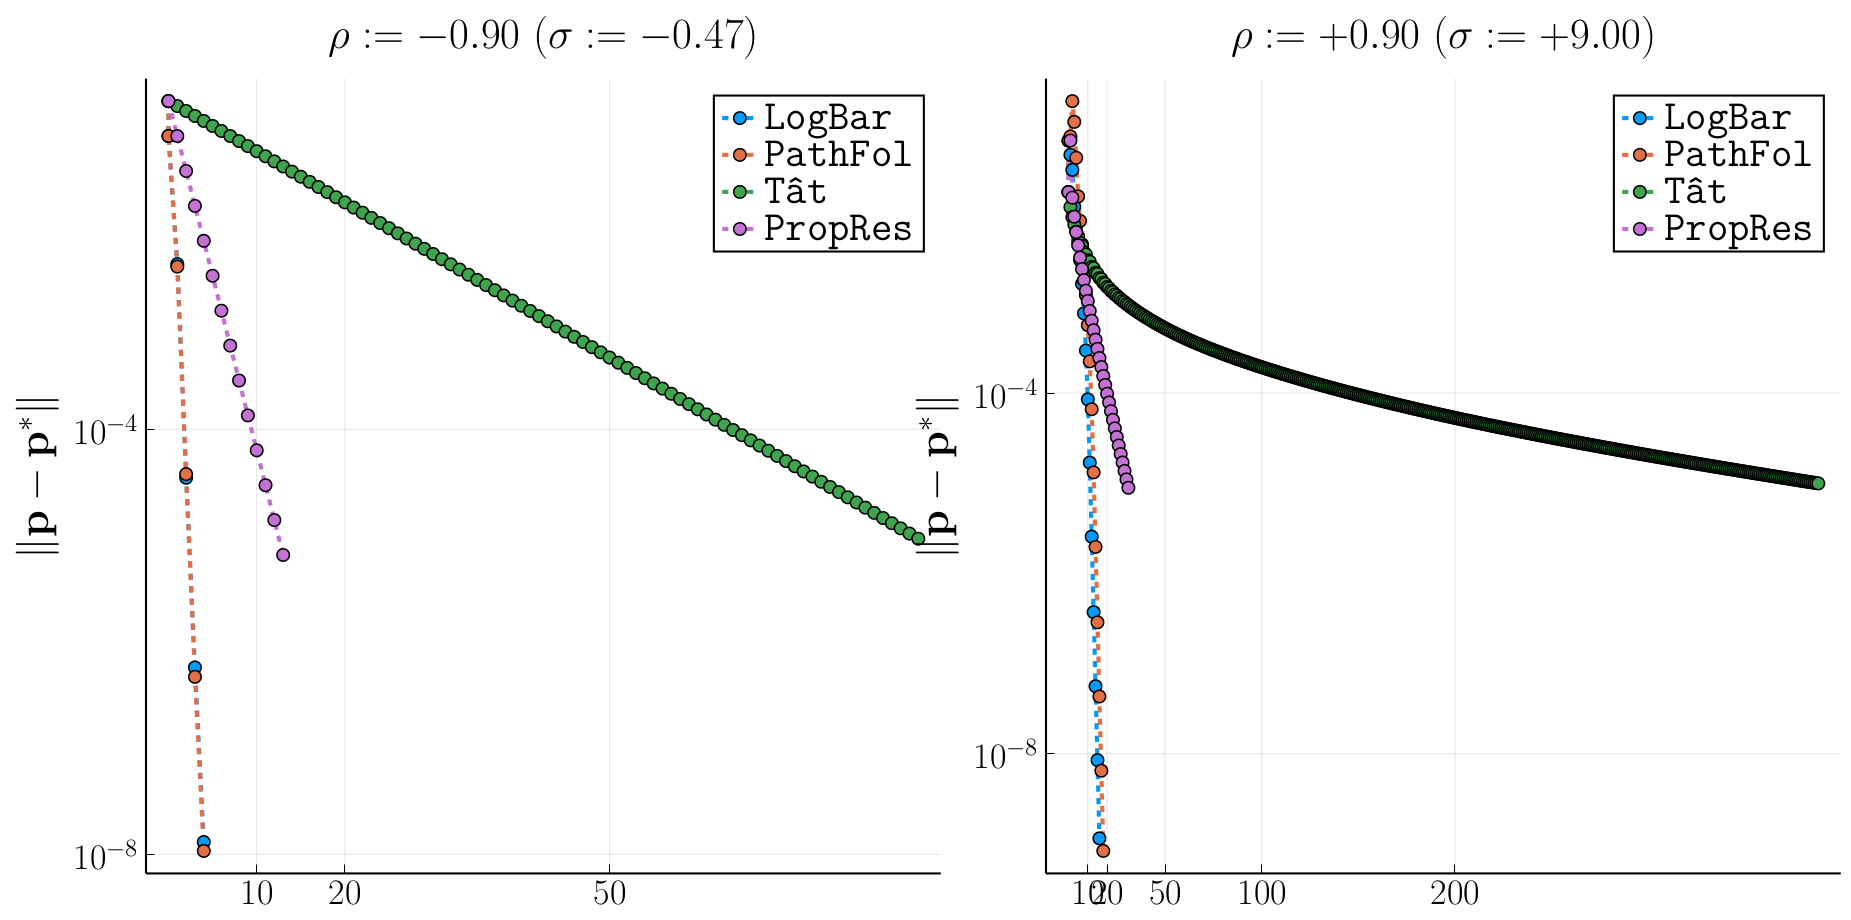

In [7]:
ff = plot(ffs...)

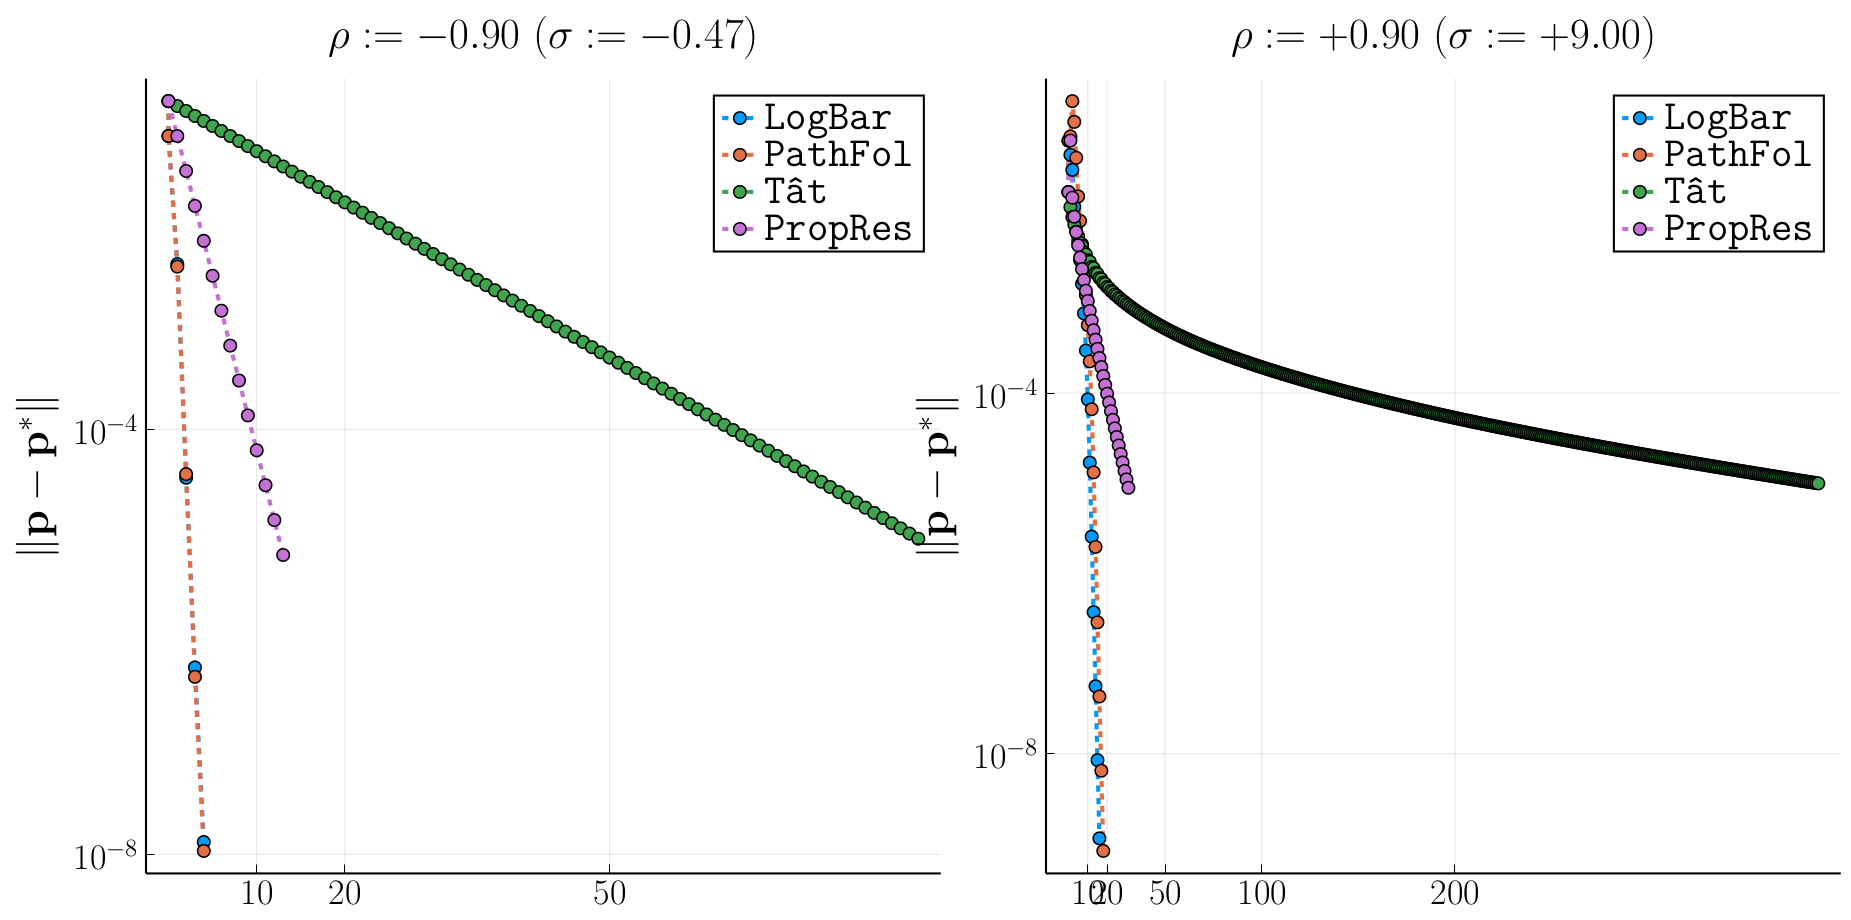

In [8]:
ff